In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.feature_selection as fs
import pickle
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocessing
from sklearn.svm import SVR, NuSVR
from sklearn.pipeline import make_pipeline

In [17]:
phil = pd.read_csv("../datasets/Philly/DO_QAQC.csv")
phil['DateTime_EST'] = pd.to_datetime(phil['DateTime_EST'])
phil = phil.rename(columns={'DateTime_EST': 'time'}, inplace=False)
phil = phil[phil['Site'] == 'U_A_0']
print(len(phil))

philweather = pd.read_csv("../datasets/Philly/phillyweather.csv")
philweather['time'] = pd.to_datetime(philweather['time'])
print(len(philweather))

25804
9720


In [18]:
# create new column in philweather called roundedNearestHour and input weather data
# time,temperature_2m (°C),relativehumidity_2m (%),precipitation (mm),surface_pressure (hPa),windspeed_10m (km/h),direct_radiation (W/m²),diffuse_radiation (W/m²)
phil['roundedNearestHour'] = phil['time'].dt.round('H')
phil['temperature_2m (°C)'] = phil['roundedNearestHour'].map(philweather.set_index('time')['temperature_2m (°C)'])
phil['relativehumidity_2m (%)'] = phil['roundedNearestHour'].map(philweather.set_index('time')['relativehumidity_2m (%)'])
phil['precipitation (mm)'] = phil['roundedNearestHour'].map(philweather.set_index('time')['precipitation (mm)'])
phil['surface_pressure (hPa)'] = phil['roundedNearestHour'].map(philweather.set_index('time')['surface_pressure (hPa)'])
phil['windspeed_10m (km/h)'] = phil['roundedNearestHour'].map(philweather.set_index('time')['windspeed_10m (km/h)'])
phil['direct_radiation (W/m²)'] = phil['roundedNearestHour'].map(philweather.set_index('time')['direct_radiation (W/m²)'])
phil['diffuse_radiation (W/m²)'] = phil['roundedNearestHour'].map(philweather.set_index('time')['diffuse_radiation (W/m²)'])


phil.head(10)

,Site,Latitude,Longitude,time,DO_mg_L,DO_pct_Sat,Depth_m,Temp_deg_C,DOLoggerType,roundedNearestHour,temperature_2m (°C),relativehumidity_2m (%),precipitation (mm),surface_pressure (hPa),windspeed_10m (km/h),direct_radiation (W/m²),diffuse_radiation (W/m²)
0,U_A_0,40.20677,-75.29545,2017-04-15 13:00:00,14.72,10.167177,0.250268,14.62,OnsetHOBO,2017-04-15 13:00:00,19.3,47,0.0,1020.0,23.9,2.0,3.0
1,U_A_0,40.20677,-75.29545,2017-04-15 13:15:00,14.64,10.189309,0.250425,14.52,OnsetHOBO,2017-04-15 13:00:00,19.3,47,0.0,1020.0,23.9,2.0,3.0
2,U_A_0,40.20677,-75.29545,2017-04-15 13:30:00,14.45,10.189309,0.245373,14.52,OnsetHOBO,2017-04-15 14:00:00,18.2,52,0.0,1020.5,23.7,0.0,0.0
3,U_A_0,40.20677,-75.29545,2017-04-15 13:45:00,14.51,10.153939,0.239689,14.68,OnsetHOBO,2017-04-15 14:00:00,18.2,52,0.0,1020.5,23.7,0.0,0.0
4,U_A_0,40.20677,-75.29545,2017-04-15 14:00:00,14.68,10.110036,0.255636,14.88,OnsetHOBO,2017-04-15 14:00:00,18.2,52,0.0,1020.5,23.7,0.0,0.0
5,U_A_0,40.20677,-75.29545,2017-04-15 14:15:00,14.86,10.049144,0.248215,15.16,OnsetHOBO,2017-04-15 14:00:00,18.2,52,0.0,1020.5,23.7,0.0,0.0
6,U_A_0,40.20677,-75.29545,2017-04-15 14:30:00,15.01,9.980356,0.251057,15.48,OnsetHOBO,2017-04-15 14:00:00,18.2,52,0.0,1020.5,23.7,0.0,0.0
7,U_A_0,40.20677,-75.29545,2017-04-15 14:45:00,15.01,9.954779,0.247268,15.60,OnsetHOBO,2017-04-15 15:00:00,17.7,54,0.0,1020.5,21.7,0.0,0.0
8,U_A_0,40.20677,-75.29545,2017-04-15 15:00:00,15.09,9.937793,0.251373,15.68,OnsetHOBO,2017-04-15 15:00:00,17.7,54,0.0,1020.5,21.7,0.0,0.0
9,U_A_0,40.20677,-75.29545,2017-04-15 15:15:00,15.09,9.920859,0.252162,15.76,OnsetHOBO,2017-04-15 15:00:00,17.7,54,0.0,1020.5,21.7,0.0,0.0


In [19]:
phil.rename(columns={
    'Temp_deg_C': 'temperature',
    'temperature_2m (°C)': 'airtemp',
    'Depth_m': 'Depth',
    'diffuse_radiation (W/m²)': 'light'
}, inplace=True)
phil.columns

Index(['Site', 'Latitude', 'Longitude', 'time', 'DO_mg_L', 'DO_pct_Sat',
       'Depth', 'temperature', 'DOLoggerType', 'roundedNearestHour', 'airtemp',
       'relativehumidity_2m (%)', 'precipitation (mm)',
       'surface_pressure (hPa)', 'windspeed_10m (km/h)',
       'direct_radiation (W/m²)', 'light'],
      dtype='object')

In [20]:
phil['Depth'] = 1.2192
phil['temperature'] = pd.to_numeric(phil['temperature'])
phil['temperature^2'] = phil['temperature'] * phil['temperature']
phil['airtemp^2'] = phil['airtemp'] * phil['airtemp']
phil['temp*airtemp'] = phil['temperature'] * phil['airtemp']
phil['depth*temp'] = phil['Depth'] * phil['temperature']

# Feature Selection

In [ ]:
nf =  pd.read_csv("../datasets/Philly/new_features.csv")
nf['time'] = phil['time']

nf.columns

In [21]:
'''
nf.rename(columns={
    'Temp_deg_C^2': 'temperature^2',
    'temperature_2m^2': 'airtemp^2',
    'Temp_2m_interaction': 'temp*airtemp',
    'Depth_Temp_interaction': 'depth*temp',
    'Depth_m': 'Depth',
    'windspeed_10m (km/h)': 'windspeed_10m (km/h)',
    'diffuse_radiation': 'light'
}, inplace=True)
'''

X_train, X_test, y_train, y_test = train_test_split(
    phil[['temperature^2', 'airtemp^2', 'temp*airtemp', 'depth*temp', 'Depth', 'windspeed_10m (km/h)', 'light']],
    phil['DO_mg_L'],
    test_size=0.2
)
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import math

def stats(y_pred_all, y_test_all):
    # Calculate the R2 score
    r2 = r2_score(y_test_all, y_pred_all)

    print(f"R2 Score: {r2:.4f}")
    # Calculate MAE
    mae = mean_absolute_error(y_test_all, y_pred_all)

    # Calculate RMSE
    mse = mean_squared_error(y_test_all, y_pred_all, squared=False)

    print("Mean Absolute Error (MAE):", mae)
    print("Root Mean Squared Error (RMSE):", math.sqrt(mse))

In [22]:
print("------------ Random Forest Results ------------")
rf = RandomForestRegressor(n_estimators=24, max_depth=40, random_state=0)
rf.fit(X_train, y_train)
print(rf.feature_importances_)
y_pred = rf.predict(X_test)
stats(y_pred, y_test)

print("------------ Decision Tree Results ------------")
from sklearn.tree import DecisionTreeRegressor
d_tree = DecisionTreeRegressor(max_depth=24)
d_tree.fit(X_train, y_train)
y_pred = d_tree.predict(X_test)
stats(y_pred, y_test)

print("------------ XG Boost Results ------------")
from sklearn.ensemble import GradientBoostingRegressor
xg_boost = GradientBoostingRegressor(learning_rate=0.1, loss='huber', max_depth=6, criterion='squared_error')
xg_boost.fit(X_train, y_train)
y_pred = xg_boost.predict(X_test)
stats(y_pred, y_test)

------------ Random Forest Results ------------
[0.20511008 0.15625613 0.08903947 0.25346874 0.         0.14390339
 0.15222219]
R2 Score: 0.9361
Mean Absolute Error (MAE): 0.5370304982882125
Root Mean Squared Error (RMSE): 0.9504608665732728
------------ Decision Tree Results ------------
R2 Score: 0.9031
Mean Absolute Error (MAE): 0.4306038593347246
Root Mean Squared Error (RMSE): 1.054625032988539
------------ XG Boost Results ------------
R2 Score: 0.7231
Mean Absolute Error (MAE): 1.3786018640524342
Root Mean Squared Error (RMSE): 1.371395132980661


In [ ]:
print("------------ Poly Regression Results ------------")
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

poly_features = PolynomialFeatures(degree=12, include_bias=True)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)
# Initialize and fit the linear regression model
poly_reg = LinearRegression()
poly_reg.fit(X_train_poly, y_train)
# Predict the target variable for training and test sets
y_pred = poly_reg.predict(X_test_poly)
stats(y_pred, y_test)

In [ ]:
print("------------ Exponential SVR Results ------------")
clf_rbf_nusvm = make_pipeline(preprocessing.SplineTransformer(), NuSVR(kernel='rbf', shrinking=True, C=1.5))
clf_rbf_nusvm.fit(X_train, y_train)
y_pred = clf_rbf_nusvm.predict(X_test)
stats(y_pred, y_test)

print("------------ Exponential SVR Results ------------")
clf_rbf_svm = make_pipeline(preprocessing.SplineTransformer(), SVR(kernel='rbf', shrinking=True, C=1.5))
clf_rbf_svm.fit(X_train[:len(X_train)//2], y_train[:len(X_train)//2])
clf_rbf_svm.fit(X_train[len(X_train)//2:], y_train[len(X_train)//2:])
y_pred = clf_rbf_svm.predict(X_test)
stats(y_pred, y_test)

print("------------ Polynomial SVR Results ------------")
clf_poly_nusvm = make_pipeline(preprocessing.SplineTransformer(), NuSVR(kernel='poly', shrinking=False, C=2.5))
clf_poly_nusvm.fit(X_train, y_train)
y_pred = clf_poly_nusvm.predict(X_test)
stats(y_pred, y_test)

In [23]:
print("------------ Bagging Results ------------")
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
base_estimator = DecisionTreeRegressor()
bag_pipe = make_pipeline(preprocessing.SplineTransformer(), BaggingRegressor(base_estimator=base_estimator, n_estimators=10, n_jobs=5))
bag_pipe.fit(X_train, y_train)
y_pred = bag_pipe.predict(X_test)
stats(y_pred, y_test)

print("------------ Extra Trees Results ------------")
from sklearn.ensemble import ExtraTreesRegressor
extra_pipe = make_pipeline(preprocessing.SplineTransformer(), ExtraTreesRegressor(n_estimators=10, n_jobs=5))
extra_pipe.fit(X_train, y_train)
y_pred = extra_pipe.predict(X_test)
stats(y_pred, y_test)

print("------------ Ada Boost Results ------------")
from sklearn.ensemble import AdaBoostRegressor
ada_pipe = make_pipeline(preprocessing.SplineTransformer(), AdaBoostRegressor(base_estimator=base_estimator, n_estimators=10))
ada_pipe.fit(X_train, y_train)
y_pred = ada_pipe.predict(X_test)
stats(y_pred, y_test)

'''
print("------------ Voting Results ------------")
from sklearn.ensemble import VotingRegressor
voting_pipe = make_pipeline(preprocessing.SplineTransformer(), VotingRegressor(estimators=[
    ('svr', NuSVR(kernel='poly', shrinking=False, C=2.5)),
    ('rf', RandomForestRegressor(n_estimators=10,random_state=42, n_jobs=8)),
    ('bag', BaggingRegressor(n_jobs=5)),
    ('bst', GradientBoostingRegressor(learning_rate=0.1, loss='huber', max_depth=6, criterion='squared_error')),
    ('n1', MLPRegressor(hidden_layer_sizes=(2,3), activation='relu')),  
    ('n2', MLPRegressor(hidden_layer_sizes=(3,2), activation='tanh'))
]))
voting_pipe.fit(X_train, y_train)
y_pred = voting_pipe.predict(X_test)
stats(y_pred, y_test)


print("------------ Stacking Results ------------")
from sklearn.ensemble import StackingRegressor
model = StackingRegressor(estimators=[
    ('svr', NuSVR(kernel='poly', shrinking=False, C=2.5)), 
    ('rf', RandomForestRegressor(n_estimators=10,random_state=42, n_jobs=8)),
    ('bag', BaggingRegressor(n_jobs=5)),
    ('bst', GradientBoostingRegressor(learning_rate=0.1, loss='huber', max_depth=6, criterion='squared_error')),
    ('n1', MLPRegressor(hidden_layer_sizes=(2,3), activation='relu')),
    ('n2', MLPRegressor(hidden_layer_sizes=(3,2), activation='tanh'))
])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
stats(y_pred, y_test)
'''


------------ Bagging Results ------------
R2 Score: 0.9255
Mean Absolute Error (MAE): 0.5788960976890448
Root Mean Squared Error (RMSE): 0.9877335523631648
------------ Extra Trees Results ------------
R2 Score: 0.9610
Mean Absolute Error (MAE): 0.34979583737001874
Root Mean Squared Error (RMSE): 0.8403076025984715
------------ Ada Boost Results ------------
R2 Score: 0.9558
Mean Absolute Error (MAE): 0.2890301722271786
Root Mean Squared Error (RMSE): 0.8665998181970094


'\nprint("------------ Voting Results ------------")\nfrom sklearn.ensemble import VotingRegressor\nvoting_pipe = make_pipeline(preprocessing.SplineTransformer(), VotingRegressor(estimators=[\n    (\'svr\', NuSVR(kernel=\'poly\', shrinking=False, C=2.5)),\n    (\'rf\', RandomForestRegressor(n_estimators=10,random_state=42, n_jobs=8)),\n    (\'bag\', BaggingRegressor(n_jobs=5)),\n    (\'bst\', GradientBoostingRegressor(learning_rate=0.1, loss=\'huber\', max_depth=6, criterion=\'squared_error\')),\n    (\'n1\', MLPRegressor(hidden_layer_sizes=(2,3), activation=\'relu\')),  \n    (\'n2\', MLPRegressor(hidden_layer_sizes=(3,2), activation=\'tanh\'))\n]))\nvoting_pipe.fit(X_train, y_train)\ny_pred = voting_pipe.predict(X_test)\nstats(y_pred, y_test)\n\n\nprint("------------ Stacking Results ------------")\nfrom sklearn.ensemble import StackingRegressor\nmodel = StackingRegressor(estimators=[\n    (\'svr\', NuSVR(kernel=\'poly\', shrinking=False, C=2.5)), \n    (\'rf\', RandomForestRegressor

# Connect to DB

In [ ]:
import pymysql

# Connect to the database
connection = pymysql.connect(
    host='localhost', 
    user='root', 
    password='N@wid2003', 
    db='dma_iot_morefish_spark_farms_v3'
)

# Create a cursor object
cursor = connection.cursor()

# Get the latest data from the database and store it in a pandas dataframe
query = "SELECT dvd_ph, dvd_temp, dvd_updated_at, dvd_do, dvd_dev_id FROM device_devicedata WHERE dvd_ph > 0 AND dvd_temp > 0 AND dvd_dev_id = 2 ORDER BY dvd_updated_at ASC"
df = pd.read_sql(query, connection)

# Close the connection
connection.close()
len(df)

In [108]:
df = pd.read_csv("../datasets/Philly/device_data_july13.csv")
df['dvd_updated_at'] = pd.to_datetime(df['dvd_updated_at'])

# SQL commands in pd
df = df[df['dvd_dev_id'] == 2]
df = df[df['dvd_do'] > 0]
df = df[df['dvd_ph'] > 0]
df = df[df['dvd_temp'] > 0]
df = df[df['dvd_temp'] < 40]
df = df[df['dvd_ph'] < 14]
df = df[df['dvd_do'] < 20]
df = df[['dvd_updated_at', 'dvd_ph', 'dvd_temp', 'dvd_do']]



In [92]:
df['dvd_updated_at'].min()

Timestamp('2023-06-22 13:50:55.441000')

In [94]:
df.rename(columns={'dvd_ph': 'ph', 'dvd_temp': 'temperature', 'dvd_updated_at': 'datetime', 'dvd_do': 'do_linreg'}, inplace=True)
df['rounded_datetime'] = pd.to_datetime(df['datetime']).dt.round('H')
# spark_weather = pd.read_csv("../../../../../../Downloads/sparkfarmsweather.csv")
spark_weather = pd.read_csv("../datasets/sparkfarmsweather.csv")
spark_weather['time'] = pd.to_datetime(spark_weather['time'])
spark_weather.rename(columns={'time': 'datetime'}, inplace=True)
# Merge the weather data with the main DataFrame based on 'rounded_datetime' column
df = df.merge(spark_weather, left_on='rounded_datetime', right_on='datetime', how='left')
df = df.drop(columns=['datetime_y'])
df.rename(columns={'datetime_x': 'datetime', 'diffuse_radiation (W/m²)': 'light', 'relativehumidity_2m (%)': 'humid', 'temperature_2m (°C)': 'airtemp' }, inplace=True)
# drop all NaN values inside diffuse radiation
df = df.dropna(subset=['light'])
df.columns

Index(['datetime', 'ph', 'temperature', 'do_linreg', 'rounded_datetime',
       'airtemp', 'humid', 'precipitation (mm)', 'surface_pressure (hPa)',
       'windspeed_10m (km/h)', 'light'],
      dtype='object')

In [84]:
# Add new features: depth, temperature^2, airtemp^2, temp*airtemp, depth*temp

df['Depth'] = 1.2192
df['temperature'] = pd.to_numeric(df['temperature'])
df['temperature^2'] = df['temperature'] * df['temperature']
df['airtemp^2'] = df['airtemp'] * df['airtemp']
df['temp*airtemp'] = df['temperature'] * df['airtemp']
df['depth*temp'] = df['Depth'] * df['temperature']

In [85]:
sf_test = df[['temperature^2', 'airtemp^2','temp*airtemp', 'depth*temp', 'Depth', 'windspeed_10m (km/h)', 'light']]
y_pred = extra_pipe.predict(sf_test)
df['do_extra'] = y_pred
df[['do_linreg', 'do_extra']].sample(10)

,do_linreg,do_extra
421,8.619,6.913
378,8.619,6.913
501,8.619,6.262
857,8.619,6.262
181,8.619,6.913
278,8.619,6.913
208,8.619,6.913
374,8.619,6.913
913,8.619,6.262
141,8.619,6.913


In [109]:
filtered_df = df[(df['datetime'] >= '2023-06-30') & (df['datetime'] <= '2023-07-01')]

# Print the filtered DataFrame
print(filtered_df)

KeyError: 'datetime'

0      8.619
1      8.619
2      8.619
3      8.619
4      8.619
       ...  
965    8.684
966    8.618
967    8.664
968    8.664
969    8.664
Name: do_linreg, Length: 970, dtype: float64


AttributeError: 'DataFrame' object has no attribute 'between'

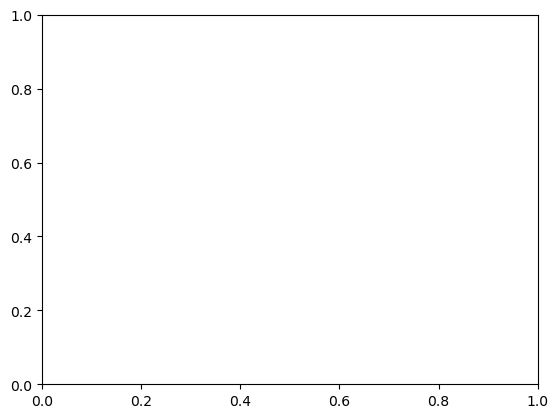

In [102]:
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

fig, ax = plt.subplots()
print(df['do_linreg'])
# convert do_linreg to numeric
df['do_linreg'] = pd.to_numeric(df['do_linreg'])
bet = df[['datetime', 'do_linreg']].between('2023-06-24', '2023-06-25')

ax.plot(bet['datetime'], bet['do_linreg'], 'bo')

myFmt = DateFormatter("%m %d %H:%M")
ax.xaxis.set_major_formatter(myFmt)

## Rotate date labels automatically
fig.autofmt_xdate()
plt.show()